In [118]:
import warnings
import json

import pandas as pd
import numpy as np

from jre_utils.datapath import (
    factor_data_paths,
    get_derived_csv_path,
    get_derived_lpa_path,
    get_derived_plps_path,
    DATA_DIRECTORY_PATH
)
from jre_utils.config import asset_types
from jre_utils.visualize import plot_time_series

from jp_prefecture.jp_cities import jp_cities as jp

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [119]:
asset_type = "building"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

dataset_paths = {
    "main": get_derived_csv_path(asset_type),
    "lpa": get_derived_lpa_path(),
    "plps": get_derived_plps_path()
}

In [120]:
granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric = metrics["weighted_median"]
metric_pct_chg = metric + "_pct_chg"

In [121]:
core_df_path = dataset_paths["main"]
df = pd.read_csv(core_df_path)
df["area_code"] = df["area_code"].astype(str)

In [122]:
# we want a framework
area_code = "5214"
area_df = df[df["area_code"] == area_code].sort_values(by="year", ascending=True)

In [126]:
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

weights = np.array([0.5, 0.5, 0.5])
weights_normalized = weights / np.sum(weights)
area_df[temporal_smoothed_metric] = area_df[metric].rolling(window=3).mean()

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [117]:
from scipy.ndimage import convolve
# Two sided smoothing. Convolutions

metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

filter_coefficients = np.array([0.5, 0.5, 0.5])
smoothed_values = np.convolve(area_df[metric], filter_coefficients, 'valid')

pad_length = len(area_df[metric]) - len(smoothed_values)
padded_smoothed_values = np.pad(smoothed_values, (pad_length, 0), mode='constant', constant_values=np.nan)

area_df[temporal_smoothed_metric] = padded_smoothed_values

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [115]:
# ma3
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric] = area_df[metric].rolling(window=3).mean()


plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [79]:
metric = metrics["weighted_median"]
temporal_smoothed_metric_tmp = f"{metric}_smoothed_temporal_tmp"
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric_tmp] = area_df[metric].rolling(window=2).mean()
area_df[temporal_smoothed_metric] = area_df[temporal_smoothed_metric_tmp].rolling(window=2).mean()


plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

In [80]:
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"
area_df[temporal_smoothed_metric] = area_df[metric].ewm(alpha=0.05).mean()

plot_time_series(
    area_df,
    metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

plot_time_series(
    area_df,
    temporal_smoothed_metric,
    group_by_columns,
    granularity_columns,
    f"Unit Price over time",
    # visible="legendonly",
    width=1000,
    height=400,
    showlegend=False
)

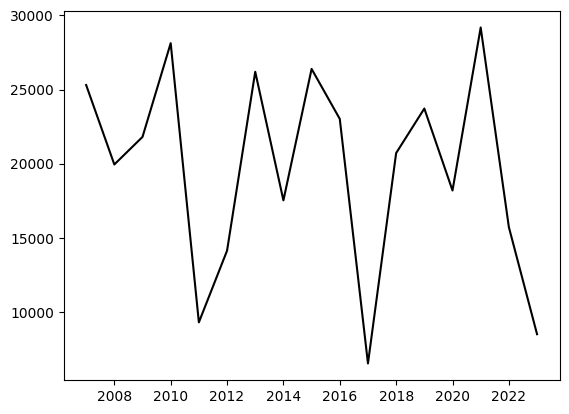

In [96]:
import matplotlib.pyplot as plt

# Fourier Transform
metric = metrics["weighted_median"]
temporal_smoothed_metric = f"{metric}_smoothed_temporal"

n = len(area_df)
fhat = np.fft.fft(area_df[metric], n)
PSD = fhat * np.conj(fhat) / n
freq = (1 / (n)) * np.arange(n)
L = np.arange(1, np.floor(n / 2), dtype="int")

# plt.plot(freq[L], PSD[L], color="k", label="PSD")

indices = PSD > 1e8
PSDclean = PSD * indices
fhat = indices * fhat
ffilt = np.fft.ifft(fhat)

plt.plot(area_df["year"], ffilt, color="k", label="filtered")

# Verdict - Pretty bad